In [1]:
# check lib
import numpy, scipy, pyarrow, sklearn, torch
import gensim, datasets, bs4
import unidecode

print("numpy:", numpy.__version__)
print("scipy:", scipy.__version__)
print("pyarrow:", pyarrow.__version__)
print("scikit-learn:", sklearn.__version__)
print("torch:", torch.__version__)

print("datasets:", datasets.__version__)
print("gensim:", gensim.__version__)
print("bs4 OK")   
print("unidecode OK")



numpy: 2.3.2
scipy: 1.16.2
pyarrow: 21.0.0
scikit-learn: 1.7.2
torch: 2.8.0+cu128
datasets: 4.2.0
gensim: 4.4.0
bs4 OK
unidecode OK


In [3]:
#load the dataset

In [4]:
# Import Libraries
import os
import pandas as pd
from datasets import Dataset, DatasetDict

# Load Kaggle CSV
data_path = "data/IMDB Dataset.csv"

df = pd.read_csv(
    data_path,
    sep=",",
    quotechar='"',
    escapechar="\\",
    engine="python",
    on_bad_lines="skip"
)

print("Original dataset shape:", df.shape)

# Convert 
df = df.rename(columns={"review": "text", "sentiment": "label"})
df["label"] = df["label"].map({"negative": 0, "positive": 1})

print("Converted dataset shape:", df.shape)
print(df["label"].value_counts())

dataset = Dataset.from_pandas(df)

# Split into Train/Validation/Test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))

train_ds = dataset.select(range(train_size))
val_ds = dataset.select(range(train_size, train_size + val_size))
test_ds = dataset.select(range(train_size + val_size, len(dataset)))

ds = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds,
})

print(ds)

# Save the split dataset
save_dir = os.path.join(os.path.dirname(data_path), "imdb_kaggle_split")
ds.save_to_disk(save_dir)
print("DatasetDict saved to:", save_dir)


Original dataset shape: (50000, 2)
Converted dataset shape: (50000, 2)
label
1    25000
0    25000
Name: count, dtype: int64
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 35000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 7500
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7500
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/35000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7500 [00:00<?, ? examples/s]

DatasetDict saved to: data/imdb_kaggle_split


In [5]:
# Load, clean, and re-save the split dataset 


In [6]:
from pathlib import Path
import re, string
from datasets import load_from_disk

# Paths
base_dir = Path("data")
load_dir = base_dir / "imdb_kaggle_split"
save_dir = base_dir / "imdb_kaggle_split_clean"

print("Loading from:", load_dir)

ds = load_from_disk(str(load_dir))

print(ds)

# Cleaning
def clean_text(text: str) -> str:
    text = "" if text is None else str(text)
    text = re.sub(r"<[^>]+>", " ", text)
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Preview
raw_before = ds["train"][0]["text"]
print("\nRAW:\n", raw_before[:500])
print("\nCLEANED:\n", clean_text(raw_before)[:500])

# Apply
def add_backup(b): return {"text_raw": b["text"]}
def clean_batch(b): return {"text": [clean_text(t) for t in b["text"]]}

for split in ds.keys():
    ds[split] = ds[split].map(add_backup, batched=True, batch_size=1000)
    ds[split] = ds[split].map(clean_batch, batched=True, batch_size=1000)
    ds[split] = ds[split].filter(lambda ex: bool(ex["text"]) and ex["text"].strip() != "")

# Save
print("\nSaving to:", save_dir)
Path(save_dir).mkdir(parents=True, exist_ok=True)
ds.save_to_disk(str(save_dir))
print("Done.")


Loading from: data/imdb_kaggle_split
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 35000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 7500
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7500
    })
})

RAW:
 One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ

CLEANED:
 one of the other reviewers has mentioned that after watching just oz episode youll be hooked they are right as this is exactly what happened with me the first

Saving the dataset (0/1 shards):   0%|          | 0/35000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7500 [00:00<?, ? examples/s]

Done.


In [7]:
#check1

In [8]:
from pathlib import Path
from datasets import load_from_disk

p = Path("data/imdb_kaggle_split_clean")
assert p.exists(), f"Not found: {p}"

print("Loading from:", p)


ds = load_from_disk(str(p))

print(ds)
print(ds["train"][0])  # quick peek

# Preview
sample = ds["train"][0]
print("RAW:\n", sample["text_raw"][:500])
print("\nCLEANED:\n", sample["text"][:500])


Loading from: data/imdb_kaggle_split_clean
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'text_raw'],
        num_rows: 35000
    })
    validation: Dataset({
        features: ['text', 'label', 'text_raw'],
        num_rows: 7500
    })
    test: Dataset({
        features: ['text', 'label', 'text_raw'],
        num_rows: 7500
    })
})
{'text': 'one of the other reviewers has mentioned that after watching just oz episode youll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all

In [9]:
#LDA

In [10]:
from pathlib import Path
import time, json
import numpy as np
import pandas as pd
from datasets import load_from_disk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

# Paths
DATA_DIR = Path("data/imdb_kaggle_split_clean")
RESULTS_DIR = Path("results"); RESULTS_DIR.mkdir(parents=True, exist_ok=True)
PRED_DIR = RESULTS_DIR / "preds"; PRED_DIR.mkdir(parents=True, exist_ok=True)

assert DATA_DIR.exists(), f"Dataset not found: {DATA_DIR.resolve()}"

# Configuration
MODEL_NAME = "lda_lr"
SEEDS = [42, 77, 4096, 9898, 2025]   # five seeds
RUNS_COLUMNS = ["run_id","seed","accuracy","macro_f1","auc","loss_val","time_sec"]

# Helpers
def append_run_csv(model_name: str, row_dict: dict):
    """Append one result row to results/<model>_runs.csv."""
    path = RESULTS_DIR / f"{model_name}_runs.csv"
    row = pd.DataFrame([row_dict], columns=RUNS_COLUMNS)
    if path.exists():
        df = pd.read_csv(path)
        df = pd.concat([df, row], ignore_index=True)
    else:
        df = row
    df.to_csv(path, index=False)

def save_preds(model_name: str, seed: int, y_true: np.ndarray, y_proba: np.ndarray):
    """Save per-sample ground truth and predicted probabilities."""
    out = PRED_DIR / f"{model_name}_seed{seed}.csv"
    pd.DataFrame({"y_true": y_true.astype(int), "y_proba": y_proba.astype(float)}).to_csv(out, index=False)
    return out

def metrics_from_scores(y_true, y_score, thr=0.5):
    """Compute Accuracy / Macro-F1 / AUC from scores (with a classification threshold)."""
    y_pred = (y_score >= thr).astype(int)
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    try:
        auc = roc_auc_score(y_true, y_score)
    except Exception:
        auc = float("nan")
    return acc, macro_f1, auc

# Single run (train → evaluate → save)
def train_eval_lda_lr(
    seed: int = 42,
    run_id: int = 1,
    n_topics: int = 50,
    max_features: int = 50000,
    min_df: int = 2,
    lr_max_iter: int = 200,
    lda_max_iter: int = 10
):
    """Single LDA+LR pass: train → evaluate → save predictions and a summary row."""
    ds = load_from_disk(str(DATA_DIR))
    y_train = np.array(ds["train"]["label"])
    y_val   = np.array(ds["validation"]["label"])
    y_test  = np.array(ds["test"]["label"])

    # Bag-of-Words
    cv = CountVectorizer(max_features=max_features, min_df=min_df, stop_words="english")
    X_train = cv.fit_transform(ds["train"]["text"])
    X_val   = cv.transform(ds["validation"]["text"])
    X_test  = cv.transform(ds["test"]["text"])

    # LDA topic model
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        learning_method="batch",
        max_iter=lda_max_iter,
        random_state=seed
    )
    t0 = time.time()
    Z_train = lda.fit_transform(X_train)
    Z_val   = lda.transform(X_val)
    Z_test  = lda.transform(X_test)

    # Logistic Regression on LDA topics
    clf = LogisticRegression(max_iter=lr_max_iter, solver="lbfgs", random_state=seed)
    clf.fit(Z_train, y_train)

    # Validation proxy loss (1 - Macro-F1 on validation set)
    val_prob = clf.predict_proba(Z_val)[:, 1]
    _, val_macro_f1, _ = metrics_from_scores(y_val, val_prob)
    loss_val = 1.0 - val_macro_f1

    # Test metrics
    test_prob = clf.predict_proba(Z_test)[:, 1]
    acc, macro_f1, auc = metrics_from_scores(y_test, test_prob)
    time_sec = time.time() - t0

    # Save per-sample predictions and summary row
    save_preds(MODEL_NAME, seed, y_test, test_prob)
    row = {
        "run_id": run_id,
        "seed": seed,
        "accuracy": float(acc),
        "macro_f1": float(macro_f1),
        "auc": float(auc),
        "loss_val": float(loss_val),
        "time_sec": float(time_sec),
    }
    append_run_csv(MODEL_NAME, row)
    print(f"[{MODEL_NAME}] run_id={run_id}, seed={seed} -> acc={acc:.4f}, f1={macro_f1:.4f}, auc={auc:.4f}")
    return row

# Multi-seed runner
def run_all_lda_lr(seeds=None):
    """Run across multiple seeds and save results."""
    seeds = seeds or SEEDS
    print(f"Running {MODEL_NAME} for seeds: {seeds}")
    for i, seed in enumerate(seeds, start=1):
        train_eval_lda_lr(seed=seed, run_id=i)
    print(f"All {MODEL_NAME} runs completed -> results/{MODEL_NAME}_runs.csv & preds/")


In [11]:
run_all_lda_lr()  


Running lda_lr for seeds: [42, 77, 4096, 9898, 2025]
[lda_lr] run_id=1, seed=42 -> acc=0.7941, f1=0.7941, auc=0.8789
[lda_lr] run_id=2, seed=77 -> acc=0.7773, f1=0.7773, auc=0.8540
[lda_lr] run_id=3, seed=4096 -> acc=0.7965, f1=0.7965, auc=0.8736
[lda_lr] run_id=4, seed=9898 -> acc=0.8065, f1=0.8065, auc=0.8821
[lda_lr] run_id=5, seed=2025 -> acc=0.8128, f1=0.8127, auc=0.8872
All lda_lr runs completed -> results/lda_lr_runs.csv & preds/


In [12]:
#Lstm

In [13]:
from pathlib import Path
import random, time, itertools
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset as TorchDataset, DataLoader
from datasets import load_from_disk
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

#  path
DATA_DIR = Path("data/imdb_kaggle_split_clean")
RESULTS_DIR = Path("results"); RESULTS_DIR.mkdir(parents=True, exist_ok=True)
PRED_DIR = RESULTS_DIR / "preds"; PRED_DIR.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "bilstm"
SEEDS = [42, 77, 4096, 9898, 2025]  # 你的 5 个 seeds
RUNS_COLUMNS = ["run_id","seed","accuracy","macro_f1","auc","loss_val","time_sec","prep_sec","train_sec","eval_sec",
                "batch_size","epochs","use_amp","vocab_size"]

assert DATA_DIR.exists(), f"Dataset not found: {DATA_DIR.resolve()}"

#  function 
def set_seed_all(seed: int):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def append_run_csv(model_name: str, row_dict: dict):
    path = RESULTS_DIR / f"{model_name}_runs.csv"
    row = pd.DataFrame([row_dict], columns=RUNS_COLUMNS)
    if path.exists():
        df = pd.read_csv(path)
        # auto filling
        for c in row.columns:
            if c not in df.columns:
                df[c] = np.nan
        df = pd.concat([df, row], ignore_index=True)
    else:
        df = row
    df.to_csv(path, index=False)

def save_preds(model_name: str, seed: int, y_true: np.ndarray, y_proba: np.ndarray):
    out = PRED_DIR / f"{model_name}_seed{seed}.csv"
    pd.DataFrame({"y_true": y_true.astype(int), "y_proba": y_proba.astype(float)}).to_csv(out, index=False)
    return out

def metrics_from_scores(y_true, y_score, thr=0.5):
    y_pred = (y_score >= thr).astype(int)
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    try: auc = roc_auc_score(y_true, y_score)
    except Exception: auc = float("nan")
    return acc, macro_f1, auc

def basic_tokenize(s: str):
    return s.lower().split()

#   vocabulary
class SimpleVocab:
    def __init__(self, tokens, min_freq=2, max_size=30000, specials=("<pad>", "<unk>")):
        from collections import Counter
        cnt = Counter(tokens)
        kept = [(tok, c) for tok, c in cnt.items() if c >= min_freq and tok not in specials]
        kept.sort(key=lambda x: x[1], reverse=True)
        kept = [tok for tok, _ in kept][:max_size - len(specials)]
        self.itos = list(specials) + kept
        self.stoi = {w:i for i,w in enumerate(self.itos)}
        self.pad_idx = self.stoi["<pad>"]; self.unk_idx = self.stoi["<unk>"]
    def encode(self, toks):
        return [self.stoi.get(t, self.unk_idx) for t in toks]
# database
class IMDBTorchDataset(TorchDataset):
    def __init__(self, texts, labels, vocab=None, max_len=256, build_vocab=False, min_freq=2, max_size=30000):
        toks = [basic_tokenize(t) for t in texts]
        if build_vocab:
            all_tokens = list(itertools.chain.from_iterable(toks))
            self.vocab = SimpleVocab(all_tokens, min_freq=min_freq, max_size=max_size)
        else:
            assert vocab is not None
            self.vocab = vocab
        self.max_len = max_len
        self.inputs = [self.vocab.encode(ts)[:max_len] for ts in toks]
        self.labels = np.array(labels, dtype=int)
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        x = self.inputs[i]
        pad = [self.vocab.pad_idx] * (self.max_len - len(x))
        x = x + pad
        return torch.tensor(x, dtype=torch.long), torch.tensor(self.labels[i], dtype=torch.long)
 
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden=256, layers=2, dropout=0.3, num_classes=2, pad_idx=0):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden, num_layers=layers,
                            dropout=0.0 if layers==1 else dropout,
                            bidirectional=True, batch_first=True)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden*2, num_classes)
    def forward(self, x):
        e = self.emb(x)
        o,(hn,cn) = self.lstm(e)
        h = torch.cat([hn[-2], hn[-1]], dim=-1)
        return self.fc(self.drop(h))

#  train 
from torch.amp import autocast, GradScaler

def train_eval_bilstm(
    seed: int = 42,
    run_id: int = 1,
    max_len: int = 256,
    min_freq: int = 2,
    vocab_max_size: int = 30000,
    epochs: int = 6,                
    bsz_train: int = 256,           
    bsz_eval: int = 256,            
    lr: float = 1e-3,               
    weight_decay: float = 0.01,    
    embed_dim: int = 256,
    hidden: int = 256,
    layers: int = 2,
    dropout: float = 0.3,
    use_amp: bool = True            
):
    from time import perf_counter
    set_seed_all(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #  load data
    print(f"[bilstm] seed={seed} | loading dataset from {DATA_DIR} ...")
    t0 = perf_counter()
    ds = load_from_disk(str(DATA_DIR))
    Xtr, ytr = ds["train"]["text"], ds["train"]["label"]
    Xva, yva = ds["validation"]["text"], ds["validation"]["label"]
    Xte, yte = ds["test"]["text"], ds["test"]["label"]

    train_ds = IMDBTorchDataset(Xtr, ytr, build_vocab=True, max_len=max_len, min_freq=min_freq, max_size=vocab_max_size)
    vocab = train_ds.vocab
    val_ds   = IMDBTorchDataset(Xva, yva, vocab=vocab, max_len=max_len)
    test_ds  = IMDBTorchDataset(Xte, yte, vocab=vocab, max_len=max_len)

    tr_dl = DataLoader(train_ds, batch_size=bsz_train, shuffle=True,  num_workers=0, pin_memory=(device.type=="cuda"))
    va_dl = DataLoader(val_ds,   batch_size=bsz_eval,  shuffle=False, num_workers=0, pin_memory=(device.type=="cuda"))
    te_dl = DataLoader(test_ds,  batch_size=bsz_eval,  shuffle=False, num_workers=0, pin_memory=(device.type=="cuda"))
    prep_sec = perf_counter() - t0


    model = BiLSTMClassifier(
        vocab_size=len(vocab.itos),
        embed_dim=embed_dim, hidden=hidden, layers=layers, dropout=dropout,
        num_classes=2, pad_idx=vocab.pad_idx
    ).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    crit = nn.CrossEntropyLoss()
    scaler = GradScaler('cuda', enabled=(use_amp and device.type=="cuda"))

    #  train 
    losses = {"train": [], "val": []}
    t_train0 = perf_counter()
    for ep in range(epochs):
        model.train(); tot=0
        for xb, yb in tr_dl:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with autocast('cuda', enabled=(use_amp and device.type=="cuda")):
                logits = model(xb)
                loss = crit(logits, yb)
            if scaler.is_enabled():
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
            else:
                loss.backward()
                opt.step()
            tot += loss.item()*xb.size(0)
        tr_loss = tot / len(train_ds)

        model.eval(); tot=0
        with torch.no_grad():
            for xb, yb in va_dl:
                xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
                with autocast('cuda', enabled=(use_amp and device.type=="cuda")):
                    logits = model(xb)
                    loss = crit(logits, yb)
                tot += loss.item()*xb.size(0)
        va_loss = tot / len(val_ds)
        losses["train"].append(tr_loss); losses["val"].append(va_loss)
        print(f"[bilstm] seed={seed} ep={ep+1}/{epochs} | train_loss={tr_loss:.4f} val_loss={va_loss:.4f}")
    train_sec = perf_counter() - t_train0

    #  test 
    t_eval0 = perf_counter()
    model.eval(); ys=[]; ps=[]
    with torch.no_grad():
        for xb, yb in te_dl:
            xb = xb.to(device, non_blocking=True)
            with autocast('cuda', enabled=(use_amp and device.type=="cuda")):
                logits = model(xb)
                prob = torch.softmax(logits, dim=-1)[:,1]
            ys.append(yb.numpy()); ps.append(prob.float().cpu().numpy())
    y_true = np.concatenate(ys); y_proba = np.concatenate(ps)
    acc, macro_f1, auc = metrics_from_scores(y_true, y_proba)
    eval_sec = perf_counter() - t_eval0
    total_sec = prep_sec + train_sec + eval_sec

    #  save 
    save_preds("bilstm", seed, y_true, y_proba)
    pd.DataFrame(losses).to_csv(RESULTS_DIR / f"bilstm_seed{seed}_learning.csv", index=False)
    row = {
        "run_id": run_id,
        "seed": seed,
        "accuracy": float(acc),
        "macro_f1": float(macro_f1),
        "auc": float(auc),
        "loss_val": float(losses["val"][-1]),
        "time_sec": float(total_sec),
        "prep_sec": float(prep_sec),
        "train_sec": float(train_sec),
        "eval_sec": float(eval_sec),
        "batch_size": int(bsz_train),
        "epochs": int(epochs),
        "use_amp": bool(use_amp and device.type=="cuda"),
        "vocab_size": int(len(vocab.itos)),
    }
    append_run_csv("bilstm", row)
    print(
        f"[bilstm] run_id={run_id}, seed={seed} -> acc={acc:.4f}, f1={macro_f1:.4f}, auc={auc:.4f} | "
        f"time total={total_sec:.2f}s (prep={prep_sec:.2f}s, train={train_sec:.2f}s, eval={eval_sec:.2f}s)"
    )
    return row


#  
def run_all_bilstm(seeds=None, **kwargs):
    seeds = seeds or SEEDS
    print(f"Running {MODEL_NAME} for seeds: {seeds}")
    for i, s in enumerate(seeds, start=1):
        train_eval_bilstm(seed=s, run_id=i, **kwargs)
    print(f"All {MODEL_NAME} runs completed -> results/{MODEL_NAME}_runs.csv & preds/")

print("BiLSTM load over.")
run_all_bilstm(epochs=6, bsz_train=256, bsz_eval=256, lr=1e-3, weight_decay=0.01,
                max_len=256, min_freq=2, vocab_max_size=30000, use_amp=True)


BiLSTM load over.
Running bilstm for seeds: [42, 77, 4096, 9898, 2025]
[bilstm] seed=42 | loading dataset from data/imdb_kaggle_split_clean ...
[bilstm] seed=42 ep=1/6 | train_loss=0.6394 val_loss=0.5857
[bilstm] seed=42 ep=2/6 | train_loss=0.5291 val_loss=0.6002
[bilstm] seed=42 ep=3/6 | train_loss=0.4767 val_loss=0.3843
[bilstm] seed=42 ep=4/6 | train_loss=0.3153 val_loss=0.3181
[bilstm] seed=42 ep=5/6 | train_loss=0.2266 val_loss=0.2985
[bilstm] seed=42 ep=6/6 | train_loss=0.1650 val_loss=0.3060
[bilstm] run_id=1, seed=42 -> acc=0.8831, f1=0.8830, auc=0.9499 | time total=48.86s (prep=3.75s, train=44.66s, eval=0.45s)
[bilstm] seed=77 | loading dataset from data/imdb_kaggle_split_clean ...
[bilstm] seed=77 ep=1/6 | train_loss=0.6134 val_loss=0.5765
[bilstm] seed=77 ep=2/6 | train_loss=0.5386 val_loss=0.5670
[bilstm] seed=77 ep=3/6 | train_loss=0.4740 val_loss=0.4833
[bilstm] seed=77 ep=4/6 | train_loss=0.4278 val_loss=0.5709
[bilstm] seed=77 ep=5/6 | train_loss=0.3279 val_loss=0.3863


In [14]:
#bert

In [24]:
from pathlib import Path
import os, time
import numpy as np
import pandas as pd
import torch

from datasets import load_from_disk
from transformers import (AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
                          Trainer, TrainingArguments, DataCollatorWithPadding)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore", message="`tokenizer` is deprecated", category=FutureWarning)

# outline
os.environ.setdefault("TRANSFORMERS_OFFLINE", "1")

# path
DATA_DIR    = Path("data/imdb_kaggle_split_clean")
HF_BASE_DIR = Path("bert_base_uncased")
RESULTS_DIR = Path("results"); RESULTS_DIR.mkdir(parents=True, exist_ok=True)
PRED_DIR    = RESULTS_DIR / "preds"; PRED_DIR.mkdir(parents=True, exist_ok=True)

MODEL_NAME  = "bert"
SEEDS       = [42, 77, 4096, 9898, 2025]
MAX_LEN     = 256

RUNS_COLUMNS = ["run_id","seed","accuracy","macro_f1","auc","loss_val",
                "time_sec","prep_sec","train_sec","eval_sec",
                "epochs","train_bsz","eval_bsz","lr","weight_decay","max_len","fp16"]

assert DATA_DIR.exists(), f"Dataset not found: {DATA_DIR.resolve()}"
assert HF_BASE_DIR.exists(), f"HF base not found: {HF_BASE_DIR.resolve()}"

#  load pre-train
snapshots_root = HF_BASE_DIR / "models--bert-base-uncased" / "snapshots"
cands = sorted([p for p in snapshots_root.glob("*") if p.is_dir()])
assert cands, f"No snapshots found under {snapshots_root.resolve()}"
MODEL_DIR = cands[0]
has_cfg = (MODEL_DIR / "config.json").exists()
has_wts = any(MODEL_DIR.glob("pytorch_model*.bin")) or any(MODEL_DIR.glob("*.safetensors"))
assert has_cfg and has_wts, f"Snapshot at {MODEL_DIR} missing weights/config."
print(f"[Using local model dir] {MODEL_DIR}")


def append_run_csv(model_name: str, row_dict: dict):
    path = RESULTS_DIR / f"{model_name}_runs.csv"
    row = pd.DataFrame([row_dict], columns=RUNS_COLUMNS)
    if path.exists():
        df = pd.read_csv(path)
        for c in row.columns:
            if c not in df.columns:
                df[c] = np.nan
        df = pd.concat([df, row], ignore_index=True)
    else:
        df = row
    df.to_csv(path, index=False)

def save_preds(model_name: str, seed: int, y_true: np.ndarray, y_proba: np.ndarray):
    out = PRED_DIR / f"{model_name}_seed{seed}.csv"
    pd.DataFrame({"y_true": y_true.astype(int), "y_proba": y_proba.astype(float)}).to_csv(out, index=False)
    return out

def metrics_from_scores(y_true, y_score, thr=0.5):
    y_pred = (y_score >= thr).astype(int)
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    try:
        auc = roc_auc_score(y_true, y_score)
    except Exception:
        auc = float("nan")
    return acc, macro_f1, auc

def prepare_bert_datasets(model_path: Path, max_len: int = 256):
    tok = AutoTokenizer.from_pretrained(str(model_path), local_files_only=True, use_fast=True)
    ds  = load_from_disk(str(DATA_DIR))
    def tok_batch(b):
        return tok(b["text"], truncation=True, padding=False, max_length=max_len)
    dtr = ds["train"].map(tok_batch, batched=True)
    dva = ds["validation"].map(tok_batch, batched=True)
    dte = ds["test"].map(tok_batch, batched=True)
    for d in (dtr, dva, dte):
        if "label" in d.column_names:
            try: d = d.rename_columns({"label": "labels"})
            except: d = d.rename_column("label", "labels")
    collator = DataCollatorWithPadding(tokenizer=tok)
    return tok, dtr, dva, dte, collator

def train_eval_bert(
    seed: int = 42,
    run_id: int = 1,
    max_len: int = MAX_LEN,
    lr: float = 2e-5,
    weight_decay: float = 0.01,
    warmup_ratio: float = 0.06,
    epochs: int = 3,
    train_bsz: int = 16,
    eval_bsz: int = 32,
    grad_accum: int = 2,
):
    torch.cuda.empty_cache()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    use_fp16 = (device == "cuda")

    #  prepare 
    prep_t0 = time.time()
    tok, dtr, dva, dte, collator = prepare_bert_datasets(MODEL_DIR, max_len=max_len)

    id2label = {0:"neg",1:"pos"}; label2id = {"neg":0,"pos":1}
    config = AutoConfig.from_pretrained(str(MODEL_DIR), num_labels=2, id2label=id2label, label2id=label2id, local_files_only=True)
    model  = AutoModelForSequenceClassification.from_pretrained(str(MODEL_DIR), config=config, local_files_only=True).to(device)

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()[:,1]
        acc, macro, roc = metrics_from_scores(labels, probs)
        return {"accuracy": acc, "macro_f1": macro, "auc": roc}

    args = TrainingArguments(
        output_dir=str(RESULTS_DIR / f"bert_ckpt_seed{seed}"),
        num_train_epochs=epochs,
        per_device_train_batch_size=train_bsz,
        per_device_eval_batch_size=eval_bsz,
        gradient_accumulation_steps=grad_accum,
        learning_rate=lr,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        eval_strategy="epoch",
        save_strategy="best",            
        logging_strategy="epoch",
        report_to=["none"],
        seed=seed,
        fp16=use_fp16,
        dataloader_num_workers=0,
        load_best_model_at_end=True,  
    )
    prep_sec = time.time() - prep_t0

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=dtr,
        eval_dataset=dva,
        tokenizer=tok,
        data_collator=collator,
        compute_metrics=compute_metrics,
    )

    #  train
    train_t0 = time.time()
    trainer.train()
    train_sec = time.time() - train_t0

    #  loss_val 
    eval_metrics = trainer.evaluate()
    loss_val = 1.0 - float(eval_metrics.get("eval_macro_f1", np.nan))

    # test
    eval_t0 = time.time()
    preds = trainer.predict(dte)
    logits = preds.predictions
    y_true = preds.label_ids
    y_proba = torch.softmax(torch.tensor(logits), dim=-1).numpy()[:,1]
    acc, macro_f1, auc = metrics_from_scores(y_true, y_proba)
    eval_sec = time.time() - eval_t0
    total_sec = prep_sec + train_sec + eval_sec

    #  save 
    save_preds(MODEL_NAME, seed, y_true, y_proba)
    hist = pd.DataFrame(trainer.state.log_history)
    if len(hist):
        hist.to_csv(RESULTS_DIR / f"{MODEL_NAME}_seed{seed}_learning.csv", index=False)

    row = {
        "run_id": run_id,
        "seed": seed,
        "accuracy": float(acc),
        "macro_f1": float(macro_f1),
        "auc": float(auc),
        "loss_val": float(loss_val),
        "time_sec": float(total_sec),
        "prep_sec": float(prep_sec),
        "train_sec": float(train_sec),
        "eval_sec": float(eval_sec),
        "epochs": int(epochs),
        "train_bsz": int(train_bsz),
        "eval_bsz": int(eval_bsz),
        "lr": float(lr),
        "weight_decay": float(weight_decay),
        "max_len": int(max_len),
        "fp16": bool(use_fp16),
    }
    append_run_csv(MODEL_NAME, row)

    print(
        f"[{MODEL_NAME}] run_id={run_id}, seed={seed} -> "
        f"acc={acc:.4f}, f1={macro_f1:.4f}, auc={auc:.4f} | "
        f"time total={total_sec:.2f}s (prep={prep_sec:.2f}s, train={train_sec:.2f}s, eval={eval_sec:.2f}s)"
    )
    return row

def run_all_bert(seeds=None, **kwargs):
    seeds = seeds or SEEDS
    print(f"Running bert for seeds: {seeds}")
    for i, s in enumerate(seeds, start=1):
        train_eval_bert(seed=s, run_id=i, **kwargs)
    print("All bert runs completed -> results/bert_runs.csv & preds/")


[Using local model dir] bert_base_uncased/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594


In [25]:
run_all_bert( epochs=3, train_bsz=16, eval_bsz=32, lr=2e-5, weight_decay=0.01, max_len=256, grad_accum=2 )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert_base_uncased/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running bert for seeds: [42, 77, 4096, 9898, 2025]


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Auc
1,0.289300,0.240792,0.911600,0.911383,0.975694
2,0.148800,0.206857,0.927200,0.927180,0.978000
3,0.086400,0.293854,0.925200,0.925200,0.976186


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert_base_uncased/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[bert] run_id=1, seed=42 -> acc=0.9252, f1=0.9252, auc=0.9761 | time total=418.31s (prep=0.36s, train=412.50s, eval=5.45s)


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Auc
1,0.298900,0.202336,0.925200,0.925190,0.974111
2,0.149700,0.204815,0.930133,0.930125,0.978447
3,0.087700,0.261632,0.930267,0.930266,0.978523


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert_base_uncased/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[bert] run_id=2, seed=77 -> acc=0.9272, f1=0.9272, auc=0.9789 | time total=425.53s (prep=0.26s, train=420.01s, eval=5.27s)


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Auc
1,0.293600,0.205816,0.922133,0.922086,0.974793
2,0.150500,0.212984,0.923333,0.923316,0.977658
3,0.088100,0.265442,0.926800,0.926797,0.976778


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert_base_uncased/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[bert] run_id=3, seed=4096 -> acc=0.9261, f1=0.9261, auc=0.9783 | time total=416.15s (prep=0.25s, train=410.61s, eval=5.29s)


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Auc
1,0.294000,0.194542,0.924133,0.924129,0.976846
2,0.146800,0.226243,0.930800,0.930799,0.978831
3,0.083700,0.273567,0.927733,0.927733,0.975975


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert_base_uncased/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[bert] run_id=4, seed=9898 -> acc=0.9267, f1=0.9267, auc=0.9779 | time total=420.94s (prep=0.23s, train=415.39s, eval=5.31s)


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Auc
1,0.289200,0.200040,0.925200,0.925188,0.976571
2,0.144700,0.205060,0.927067,0.927056,0.978973
3,0.079700,0.274315,0.928933,0.928932,0.977018


[bert] run_id=5, seed=2025 -> acc=0.9280, f1=0.9280, auc=0.9788 | time total=427.76s (prep=0.26s, train=422.20s, eval=5.31s)
All bert runs completed -> results/bert_runs.csv & preds/


In [ ]:
#LDA+BERT

In [29]:
from pathlib import Path
import os, time, json, math, shutil, random
import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup, DataCollatorWithPadding
from torch.optim import AdamW
from tqdm import tqdm

MAX_LEN = 192
EPOCHS = 2
TRAIN_BSZ, EVAL_BSZ, GRAD_ACCUM = 12, 24, 2
LR, WEIGHT_DECAY, WARMUP_RATIO = 2e-5, 0.01, 0.06
FREEZE_BERT = False
LDA_TOPICS, LDA_MAX_FEATS = 20, 20000
SEEDS = [42, 77, 4096, 9898, 2025]

# Paths
DATA_DIR = Path("data/imdb_kaggle_split_clean")
RESULTS_DIR = Path("results"); RESULTS_DIR.mkdir(parents=True, exist_ok=True)
PRED_DIR = RESULTS_DIR / "preds"; PRED_DIR.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "lda_bert"
RUNS_PATH = RESULTS_DIR / f"{MODEL_NAME}_runs.csv"

# Environment and device/precision settings
os.environ.setdefault("TRANSFORMERS_OFFLINE", "1")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BF16_OK = (device.type == "cuda" and torch.cuda.is_bf16_supported())
AMP_DTYPE = torch.bfloat16 if BF16_OK else (torch.float16 if device.type == "cuda" else torch.float32)

try:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

# Locate local BERT snapshot
HF_BASE_DIR = Path("bert_base_uncased")
snapshots_root = HF_BASE_DIR / "models--bert-base-uncased" / "snapshots"
cands = sorted([p for p in snapshots_root.glob("*") if p.is_dir()])
assert cands, f"No snapshots in {snapshots_root.resolve()}"
MODEL_DIR = cands[0]
assert (MODEL_DIR / "config.json").exists(), "Missing config.json"
print(f"[Using local BERT] {MODEL_DIR}")

# Utility functions
def set_seed_all(seed:int):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def append_run_csv(row_dict: dict):
    """Append one run’s results to runs.csv; auto-add new columns if needed."""
    row = pd.DataFrame([row_dict])
    if RUNS_PATH.exists():
        df = pd.read_csv(RUNS_PATH)
        for c in row.columns:
            if c not in df.columns:
                df[c] = np.nan
        df = pd.concat([df, row], ignore_index=True)
    else:
        df = row
    df.to_csv(RUNS_PATH, index=False)

def save_preds(seed:int, y_true: np.ndarray, y_proba: np.ndarray):
    """Save per-sample ground truth and predicted probabilities for a given seed."""
    out = PRED_DIR / f"{MODEL_NAME}_seed{seed}.csv"
    pd.DataFrame({"y_true": y_true.astype(int), "y_proba": y_proba.astype(float)}).to_csv(out, index=False)
    return out

def load_imdb_splits(data_dir: Path):
    """Load IMDb train/validation/test splits from a local HF dataset."""
    from datasets import load_from_disk
    ds = load_from_disk(str(data_dir))
    to_df = lambda d: pd.DataFrame({"text": d["text"], "label": d["label"]})
    return to_df(ds["train"]), to_df(ds["validation"]), to_df(ds["test"])

# Train LDA (per-seed) and produce topic-proportion features
def build_lda_features(df_train, df_val, df_test, seed:int):
    vectorizer = CountVectorizer(max_features=LDA_MAX_FEATS, stop_words="english")
    X_tr = vectorizer.fit_transform(df_train["text"].tolist())
    lda_model = LatentDirichletAllocation(
        n_components=LDA_TOPICS, learning_method="batch", max_iter=20, random_state=seed
    )
    Z_tr = lda_model.fit_transform(X_tr)
    Z_va = lda_model.transform(vectorizer.transform(df_val["text"].tolist()))
    Z_te = lda_model.transform(vectorizer.transform(df_test["text"].tolist()))
    return (Z_tr.astype(np.float32), Z_va.astype(np.float32), Z_te.astype(np.float32))

# Tokenizer and collator
def tokenize_all(MODEL_DIR, df_train, df_val, df_test):
    tok = AutoTokenizer.from_pretrained(str(MODEL_DIR), local_files_only=True)
    def encode_texts(texts): return tok(texts, truncation=True, max_length=MAX_LEN)
    enc_train, enc_val, enc_test = (encode_texts(df["text"].tolist()) for df in (df_train, df_val, df_test))
    collator = DataCollatorWithPadding(tokenizer=tok, pad_to_multiple_of=8)
    return tok, enc_train, enc_val, enc_test, collator

# Dataset and DataLoader
class ComboDataset(Dataset):
    """Dataset combining BERT inputs and LDA topic vectors."""
    def __init__(self, enc, labels, lda_vecs):
        self.input_ids, self.attn, self.labels = enc["input_ids"], enc["attention_mask"], labels
        self.lda = lda_vecs
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        return {
            "input_ids": torch.tensor(self.input_ids[i], dtype=torch.long),
            "attention_mask": torch.tensor(self.attn[i], dtype=torch.long),
            "labels": torch.tensor(int(self.labels[i]), dtype=torch.long),
            "lda": torch.tensor(self.lda[i], dtype=torch.float32),
        }

def make_loaders(enc_tr, enc_va, enc_te, df_tr, df_va, df_te, collator):
    """Create datasets and a collate_fn that merges BERT batch and LDA vectors."""
    train_ds = ComboDataset(enc_tr, df_tr["label"].values, None)  # LDA injected later
    val_ds   = ComboDataset(enc_va, df_va["label"].values, None)
    test_ds  = ComboDataset(enc_te, df_te["label"].values, None)
    def collate_fn(batch):
        core = [{"input_ids": b["input_ids"], "attention_mask": b["attention_mask"], "labels": b["labels"]} for b in batch]
        bert_batch = collator(core)
        bert_batch["lda"] = torch.stack([b["lda"] for b in batch], dim=0)
        return bert_batch
    return train_ds, val_ds, test_ds, collate_fn

# Model
class LDABERT(nn.Module):
    """Early-fusion model: concatenate LDA topic proportions with BERT pooled output."""
    def __init__(self, model_dir, n_topics, n_labels=2, dropout=0.2):
        super().__init__()
        self.bert = AutoModel.from_pretrained(str(model_dir), local_files_only=True)
        self.dropout = nn.Dropout(dropout)
        hidden = self.bert.config.hidden_size
        self.fc = nn.Sequential(
            nn.Linear(hidden + n_topics, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, n_labels)
        )
    def forward(self, input_ids, attention_mask, lda):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = out.pooler_output if getattr(out, "pooler_output", None) is not None else out.last_hidden_state[:, 0]
        x = torch.cat([pooled, lda], dim=1)
        x = self.dropout(x)
        return self.fc(x)

# Training and evaluation for one seed
def train_eval_lda_bert(
    seed:int=42, run_id:int=1,
    epochs:int=EPOCHS, train_bsz:int=TRAIN_BSZ, eval_bsz:int=EVAL_BSZ, grad_accum:int=GRAD_ACCUM,
    lr:float=LR, weight_decay:float=WEIGHT_DECAY, warmup_ratio:float=WARMUP_RATIO,
    freeze_bert:bool=FREEZE_BERT
):
    set_seed_all(seed)
    torch.cuda.empty_cache()

    df_train, df_val, df_test = load_imdb_splits(DATA_DIR)
    tok, enc_tr, enc_va, enc_te, collator = tokenize_all(MODEL_DIR, df_train, df_val, df_test)
    # Build datasets and collate function
    train_ds, val_ds, test_ds, collate_fn = make_loaders(enc_tr, enc_va, enc_te, df_train, df_val, df_test, collator)

    # Fit LDA (seeded) and attach features
    Z_tr, Z_va, Z_te = build_lda_features(df_train, df_val, df_test, seed=seed)
    train_ds.lda, val_ds.lda, test_ds.lda = Z_tr, Z_va, Z_te

    # DataLoaders
    tr_loader = DataLoader(train_ds, batch_size=train_bsz, shuffle=True,  collate_fn=collate_fn, num_workers=0)
    va_loader = DataLoader(val_ds,   batch_size=eval_bsz,  shuffle=False, collate_fn=collate_fn, num_workers=0)
    te_loader = DataLoader(test_ds,  batch_size=eval_bsz,  shuffle=False, collate_fn=collate_fn, num_workers=0)

    # Optimizer / scheduler / loss / AMP
    model = LDABERT(MODEL_DIR, n_topics=LDA_TOPICS).to(device)
    if freeze_bert:
        for n, p in model.named_parameters():
            if n.startswith("bert."): p.requires_grad = False
    trainable = [p for p in model.parameters() if p.requires_grad]
    optim = AdamW(trainable, lr=lr, weight_decay=weight_decay)

    num_steps = math.ceil(len(tr_loader) / grad_accum) * epochs
    sched = get_linear_schedule_with_warmup(optim, int(num_steps * warmup_ratio), num_steps)
    ce = nn.CrossEntropyLoss()
    scaler = torch.amp.GradScaler("cuda", enabled=(device.type=="cuda"))

    def run_epoch(loader, train=True, desc=""):
        """One pass over a loader: returns (loss, acc, macro_f1, auc)."""
        model.train() if train else model.eval()
        tot_loss = 0.0; nb = 0
        preds, labels_all, probs = [], [], []
        loop = tqdm(loader, desc=desc, leave=False)
        optim.zero_grad(set_to_none=True)
        for step, batch in enumerate(loop, 1):
            ids  = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            y    = batch["labels"].to(device)
            lda  = batch["lda"].to(device)

            with torch.amp.autocast("cuda", enabled=(device.type=="cuda"),
                                    dtype=AMP_DTYPE if device.type=="cuda" else None):
                logits = model(ids, attn, lda)
                loss = ce(logits, y)

            if train:
                scaler.scale(loss).backward()
                if step % grad_accum == 0:
                    scaler.step(optim); scaler.update()
                    optim.zero_grad(set_to_none=True)
                    sched.step()

            tot_loss += float(loss.detach()); nb += 1
            loop.set_postfix(loss=float(loss.detach()))

            with torch.no_grad():
                p1 = torch.softmax(logits.detach().float(), dim=1)[:, 1].cpu().numpy()
                preds.append((p1 >= 0.5).astype(int))
                labels_all.append(y.detach().cpu().numpy())
                probs.append(p1)

        # Handle tail steps that did not trigger an optimizer step due to grad accumulation
        if train and (step % grad_accum != 0):
            scaler.step(optim); scaler.update()
            optim.zero_grad(set_to_none=True); sched.step()

        preds = np.concatenate(preds); labels_all = np.concatenate(labels_all); probs = np.concatenate(probs)
        acc = accuracy_score(labels_all, preds)
        f1  = f1_score(labels_all, preds, average="macro")
        try: auc = roc_auc_score(labels_all, probs)
        except Exception: auc = float("nan")
        return tot_loss/nb, acc, f1, auc

    prep_sec = 0.0
    t_train0 = time.time()
    logs = {"epoch": [], "train_loss": [], "val_loss": [], "val_acc": [], "val_f1": [], "val_auc": []}
    for ep in range(1, epochs+1):
        tr = run_epoch(tr_loader, True,  desc=f"Train {ep}/{epochs}")
        va = run_epoch(va_loader, False, desc=f"Val   {ep}/{epochs}")
        logs["epoch"].append(ep)
        logs["train_loss"].append(tr[0])
        logs["val_loss"].append(va[0])
        logs["val_acc"].append(va[1])
        logs["val_f1"].append(va[2])
        logs["val_auc"].append(va[3])
        print(f"[{MODEL_NAME}] seed={seed} ep={ep}/{epochs} | train_loss={tr[0]:.4f} "
              f"val_loss={va[0]:.4f} val_acc={va[1]:.4f} val_f1={va[2]:.4f} val_auc={va[3]:.4f}")
    train_sec = time.time() - t_train0

    t_eval0 = time.time()
    te = run_epoch(te_loader, False, desc="Test")
    eval_sec = time.time() - t_eval0
    total_sec = prep_sec + train_sec + eval_sec

    # Save per-sample predictions (from test set)
    yts, yps = [], []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(te_loader, desc="Save preds", leave=False):
            ids  = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            lda  = batch["lda"].to(device)
            y    = batch["labels"].cpu().numpy()
            with torch.amp.autocast("cuda", enabled=(device.type=="cuda"),
                                    dtype=AMP_DTYPE if device.type=="cuda" else None):
                logits = model(ids, attn, lda)
                p1 = torch.softmax(logits.detach().float(), dim=1)[:, 1].cpu().numpy()
            yts.append(y); yps.append(p1)
    y_true = np.concatenate(yts); y_proba = np.concatenate(yps)
    save_preds(seed, y_true, y_proba)

    # Save learning curve logs
    pd.DataFrame(logs).to_csv(RESULTS_DIR / f"{MODEL_NAME}_seed{seed}_learning.csv", index=False)

    # Write summary row into runs.csv
    row = {
        "run_id": run_id, "seed": seed,
        "accuracy": float(te[1]), "macro_f1": float(te[2]), "auc": float(te[3]),
        "loss_val": float(logs["val_loss"][-1]) if len(logs["val_loss"]) else np.nan,
        "time_sec": float(total_sec), "prep_sec": float(prep_sec),
        "train_sec": float(train_sec), "eval_sec": float(eval_sec),
        "epochs": int(epochs), "train_bsz": int(train_bsz), "eval_bsz": int(eval_bsz),
        "lr": float(lr), "weight_decay": float(weight_decay), "max_len": int(MAX_LEN),
        "fp16_or_bf16": "bf16" if BF16_OK else ("fp16" if device.type=="cuda" else "fp32"),
        "lda_topics": int(LDA_TOPICS), "lda_max_feats": int(LDA_MAX_FEATS),
        "freeze_bert": bool(freeze_bert),
    }
    append_run_csv(row)

    print(
        f"[{MODEL_NAME}] run_id={run_id}, seed={seed} -> "
        f"acc={te[1]:.4f}, f1={te[2]:.4f}, auc={te[3]:.4f} | "
        f"time total={total_sec:.2f}s (train={train_sec:.2f}s, eval={eval_sec:.2f}s)"
    )
    return row


def run_all_lda_bert(seeds=None, **kwargs):
    """Run LDA-BERT across multiple seeds and log results."""
    seeds = seeds or SEEDS
    print(f"Running {MODEL_NAME} for seeds: {seeds}")
    for i, s in enumerate(seeds, start=1):
        train_eval_lda_bert(seed=s, run_id=i, **kwargs)
    print(f"All {MODEL_NAME} runs completed -> {RUNS_PATH} & preds/")


[Using local BERT] bert_base_uncased/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594


In [30]:
run_all_lda_bert(
    epochs=2,
    train_bsz=12, eval_bsz=24, grad_accum=2,
    lr=2e-5, weight_decay=0.01, warmup_ratio=0.06,
    freeze_bert=False
)


Running lda_bert for seeds: [42, 77, 4096, 9898, 2025]


[lda_bert] seed=42 ep=1/2 | train_loss=0.2984 val_loss=0.2198 val_acc=0.9140 val_f1=0.9140 val_auc=0.9718


[lda_bert] seed=42 ep=2/2 | train_loss=0.1481 val_loss=0.2162 val_acc=0.9197 val_f1=0.9197 val_auc=0.9739


[lda_bert] run_id=1, seed=42 -> acc=0.9185, f1=0.9185, auc=0.9751 | time total=370.42s (train=366.54s, eval=3.88s)


[lda_bert] seed=77 ep=1/2 | train_loss=0.2935 val_loss=0.2154 val_acc=0.9143 val_f1=0.9142 val_auc=0.9724


[lda_bert] seed=77 ep=2/2 | train_loss=0.1440 val_loss=0.2136 val_acc=0.9211 val_f1=0.9211 val_auc=0.9747


[lda_bert] run_id=2, seed=77 -> acc=0.9191, f1=0.9191, auc=0.9761 | time total=376.86s (train=372.97s, eval=3.89s)


[lda_bert] seed=4096 ep=1/2 | train_loss=0.3040 val_loss=0.2128 val_acc=0.9155 val_f1=0.9155 val_auc=0.9721


[lda_bert] seed=4096 ep=2/2 | train_loss=0.1478 val_loss=0.2147 val_acc=0.9212 val_f1=0.9212 val_auc=0.9743


[lda_bert] run_id=3, seed=4096 -> acc=0.9187, f1=0.9187, auc=0.9749 | time total=364.80s (train=360.97s, eval=3.83s)


[lda_bert] seed=9898 ep=1/2 | train_loss=0.2941 val_loss=0.2080 val_acc=0.9191 val_f1=0.9191 val_auc=0.9736


[lda_bert] seed=9898 ep=2/2 | train_loss=0.1487 val_loss=0.2131 val_acc=0.9221 val_f1=0.9221 val_auc=0.9751


[lda_bert] run_id=4, seed=9898 -> acc=0.9169, f1=0.9169, auc=0.9746 | time total=364.29s (train=360.36s, eval=3.93s)


[lda_bert] seed=2025 ep=1/2 | train_loss=0.2977 val_loss=0.2153 val_acc=0.9177 val_f1=0.9177 val_auc=0.9725


[lda_bert] seed=2025 ep=2/2 | train_loss=0.1445 val_loss=0.2209 val_acc=0.9179 val_f1=0.9179 val_auc=0.9733


[lda_bert] run_id=5, seed=2025 -> acc=0.9191, f1=0.9191, auc=0.9755 | time total=346.93s (train=343.06s, eval=3.87s)
All lda_bert runs completed -> results/lda_bert_runs.csv & preds/


In [31]:
#BERT+LSTM

In [33]:
from pathlib import Path
import os, time, json, math, random
import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup, DataCollatorWithPadding
from torch.optim import AdamW
from tqdm import tqdm

# Hyperparameters (consistent with original configuration)
MAX_LEN = 192
EPOCHS = 2
TRAIN_BSZ, EVAL_BSZ, GRAD_ACCUM = 12, 24, 2
LR, WEIGHT_DECAY, WARMUP_RATIO = 2e-5, 0.01, 0.06
FREEZE_BERT = False
HID, LAYERS, DROPOUT = 256, 1, 0.2
SEEDS = [42, 77, 4096, 9898, 2025]

# Paths
DATA_DIR = Path("data/imdb_kaggle_split_clean")
RESULTS_DIR = Path("results"); RESULTS_DIR.mkdir(parents=True, exist_ok=True)
PRED_DIR    = RESULTS_DIR / "preds"; PRED_DIR.mkdir(parents=True, exist_ok=True)
MODEL_NAME  = "bert_bilstm"
RUNS_PATH   = RESULTS_DIR / f"{MODEL_NAME}_runs.csv"

# Offline mode and device / precision setup
os.environ.setdefault("TRANSFORMERS_OFFLINE", "1")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BF16_OK = (device.type == "cuda" and torch.cuda.is_bf16_supported())
AMP_DTYPE = torch.bfloat16 if BF16_OK else (torch.float16 if device.type=="cuda" else torch.float32)
USE_AMP = (device.type == "cuda")  # Enable AMP only on CUDA devices

try:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

# Locate local BERT snapshot
HF_BASE_DIR = Path("bert_base_uncased")
snapshots_root = HF_BASE_DIR / "models--bert-base-uncased" / "snapshots"
cands = sorted([p for p in snapshots_root.glob("*") if p.is_dir()])
assert cands, f"No snapshots in {snapshots_root.resolve()}"
MODEL_DIR = cands[0]
assert (MODEL_DIR / "config.json").exists(), "Missing config.json"
print(f"[Using local BERT] {MODEL_DIR}")

# Utility functions
def set_seed_all(seed:int):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def append_run_csv(row_dict: dict):
    """Append a single run’s results to the CSV summary (auto-add new columns if needed)."""
    row = pd.DataFrame([row_dict])
    if RUNS_PATH.exists():
        df = pd.read_csv(RUNS_PATH)
        # Add any missing columns dynamically
        for c in row.columns:
            if c not in df.columns:
                df[c] = np.nan
        df = pd.concat([df, row], ignore_index=True)
    else:
        df = row
    df.to_csv(RUNS_PATH, index=False)

def save_preds(seed:int, y_true: np.ndarray, y_proba: np.ndarray):
    """Save prediction probabilities and ground truth for a given seed."""
    out = PRED_DIR / f"{MODEL_NAME}_seed{seed}.csv"
    pd.DataFrame({"y_true": y_true.astype(int), "y_proba": y_proba.astype(float)}).to_csv(out, index=False)
    return out

# Dataset loading
def load_imdb_splits(data_dir: Path):
    from datasets import load_from_disk
    ds = load_from_disk(str(data_dir))
    to_df = lambda d: pd.DataFrame({"text": d["text"], "label": d["label"]})
    return to_df(ds["train"]), to_df(ds["validation"]), to_df(ds["test"])

# Tokenizer, collator, and dataset preparation
def tokenize_all(model_dir, df_train, df_val, df_test):
    tok = AutoTokenizer.from_pretrained(str(model_dir), local_files_only=True)
    def encode_texts(texts): return tok(texts, truncation=True, max_length=MAX_LEN)
    enc_train, enc_val, enc_test = (encode_texts(df["text"].tolist()) for df in (df_train, df_val, df_test))
    collator = DataCollatorWithPadding(tokenizer=tok, pad_to_multiple_of=8)
    return tok, enc_train, enc_val, enc_test, collator

class EncDataset(Dataset):
    """Simple dataset wrapper for tokenized IMDb reviews."""
    def __init__(self, enc, labels):
        self.input_ids, self.attn, self.labels = enc["input_ids"], enc["attention_mask"], labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        return {
            "input_ids": torch.tensor(self.input_ids[i], dtype=torch.long),
            "attention_mask": torch.tensor(self.attn[i], dtype=torch.long),
            "labels": torch.tensor(int(self.labels[i]), dtype=torch.long),
        }

def make_loaders(enc_tr, enc_va, enc_te, df_tr, df_va, df_te, collator):
    """Create train/validation/test DataLoaders with consistent padding and pinning."""
    train_ds = EncDataset(enc_tr, df_tr["label"].values)
    val_ds   = EncDataset(enc_va, df_va["label"].values)
    test_ds  = EncDataset(enc_te, df_te["label"].values)
    def collate_fn(batch): return collator(batch)
    pin = (device.type == "cuda")
    tr_loader = DataLoader(train_ds, batch_size=TRAIN_BSZ, shuffle=True,  collate_fn=collate_fn, num_workers=0, pin_memory=pin)
    va_loader = DataLoader(val_ds,   batch_size=EVAL_BSZ,  shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=pin)
    te_loader = DataLoader(test_ds,  batch_size=EVAL_BSZ,  shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=pin)
    return tr_loader, va_loader, te_loader

# Model definition
class BERT_BiLSTM(nn.Module):
    """Hybrid architecture combining BERT embeddings with a bidirectional LSTM."""
    def __init__(self, model_dir, hid=256, layers=1, dropout=0.2, n_labels=2):
        super().__init__()
        self.bert = AutoModel.from_pretrained(str(model_dir), local_files_only=True)
        emb_dim = self.bert.config.hidden_size
        self.lstm = nn.LSTM(emb_dim, hid, num_layers=layers, batch_first=True,
                            bidirectional=True, dropout=dropout if layers > 1 else 0.0)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(hid * 2, n_labels)
    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        token_emb = out.last_hidden_state                # [B, L, H]
        lstm_out, _ = self.lstm(token_emb)               # [B, L, 2*hid]
        # Masked max-pooling
        mask = (attention_mask > 0).unsqueeze(-1)        # [B, L, 1]
        neg_inf = torch.finfo(lstm_out.dtype).min
        lstm_out_masked = torch.where(mask, lstm_out, torch.full_like(lstm_out, neg_inf))
        max_pool, _ = torch.max(lstm_out_masked, dim=1)  # [B, 2*hid]
        x = self.drop(max_pool)
        return self.fc(x)                                # [B, 2]

# Single-seed training and evaluation
def train_eval_bert_bilstm(
    seed:int=42, run_id:int=1,
    epochs:int=EPOCHS,
    train_bsz:int=TRAIN_BSZ, eval_bsz:int=EVAL_BSZ, grad_accum:int=GRAD_ACCUM,
    lr:float=LR, weight_decay:float=WEIGHT_DECAY, warmup_ratio:float=WARMUP_RATIO,
    freeze_bert:bool=FREEZE_BERT,
    grad_clip: float = 1.0  # Optional gradient clipping
):
    set_seed_all(seed)
    torch.cuda.empty_cache()

    # Data preparation
    prep_t0 = time.time()
    df_train, df_val, df_test = load_imdb_splits(DATA_DIR)
    tok, enc_tr, enc_va, enc_te, collator = tokenize_all(MODEL_DIR, df_train, df_val, df_test)
    tr_loader, va_loader, te_loader = make_loaders(enc_tr, enc_va, enc_te, df_train, df_val, df_test, collator)

    # Model setup
    model = BERT_BiLSTM(MODEL_DIR, hid=HID, layers=LAYERS, dropout=DROPOUT).to(device)
    if freeze_bert:
        for n, p in model.named_parameters():
            if n.startswith("bert."): 
                p.requires_grad = False

    # Optimizer, scheduler, loss, and AMP
    trainable = [p for p in model.parameters() if p.requires_grad]
    optim = AdamW(trainable, lr=lr, weight_decay=weight_decay)
    num_steps = math.ceil(len(tr_loader)/grad_accum) * epochs
    sched = get_linear_schedule_with_warmup(optim, int(num_steps*warmup_ratio), num_steps)
    scaler = torch.amp.GradScaler("cuda", enabled=USE_AMP)
    ce = nn.CrossEntropyLoss()

    prep_sec = time.time() - prep_t0

    # Epoch loop helper
    def run_epoch(loader, train=True, desc=""):
        model.train() if train else model.eval()
        tot, nb = 0.0, 0
        preds, labels_all, probs = [], [], []
        loop = tqdm(loader, desc=desc, leave=False)

        if train:
            optim.zero_grad(set_to_none=True)

        for step, batch in enumerate(loop, 1):
            ids  = batch["input_ids"].to(device, non_blocking=True)
            attn = batch["attention_mask"].to(device, non_blocking=True)
            y    = batch["labels"].to(device, non_blocking=True)

            with torch.amp.autocast("cuda", enabled=USE_AMP, dtype=AMP_DTYPE):
                logits = model(ids, attn)
                loss = ce(logits, y)
                if train and grad_accum > 1:
                    loss = loss / grad_accum  

            if train:
                if USE_AMP:
                    scaler.scale(loss).backward()
                else:
                    loss.backward()

                do_step = (step % grad_accum == 0) or (step == len(loader))
                if do_step:
                    if USE_AMP:
                        scaler.unscale_(optim)  
                    if grad_clip and grad_clip > 0:
                        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

                    if USE_AMP:
                        scaler.step(optim)
                        scaler.update()
                    else:
                        optim.step()

                    sched.step()
                    optim.zero_grad(set_to_none=True)

            tot += float(loss.detach())
            nb  += 1
            loop.set_postfix(loss=float(loss.detach()))

            with torch.no_grad():
                p1 = torch.softmax(logits.detach().float(), dim=1)[:,1].cpu().numpy()
                preds.append((p1>=0.5).astype(int))
                labels_all.append(y.detach().cpu().numpy())
                probs.append(p1)

        preds = np.concatenate(preds); labels_all = np.concatenate(labels_all); probs = np.concatenate(probs)
        acc = accuracy_score(labels_all, preds)
        f1  = f1_score(labels_all, preds, average="macro")
        try: auc = roc_auc_score(labels_all, probs)
        except Exception: auc = float("nan")
        return tot/nb, acc, f1, auc

    # Training phase
    t_train0 = time.time()
    logs = {"epoch": [], "train_loss": [], "val_loss": [], "val_acc": [], "val_f1": [], "val_auc": []}
    for ep in range(1, epochs+1):
        tr = run_epoch(tr_loader, True,  desc=f"Train {ep}/{epochs}")
        va = run_epoch(va_loader, False, desc=f"Val   {ep}/{epochs}")
        logs["epoch"].append(ep)
        logs["train_loss"].append(tr[0])
        logs["val_loss"].append(va[0])
        logs["val_acc"].append(va[1])
        logs["val_f1"].append(va[2])
        logs["val_auc"].append(va[3])
        print(f"[{MODEL_NAME}] seed={seed} ep={ep}/{epochs} | train_loss={tr[0]:.4f} "
              f"val_loss={va[0]:.4f} val_acc={va[1]:.4f} val_f1={va[2]:.4f} val_auc={va[3]:.4f}")
    train_sec = time.time() - t_train0

    # Evaluation phase
    t_eval0 = time.time()
    te = run_epoch(te_loader, False, desc="Test")
    eval_sec = time.time() - t_eval0
    total_sec = prep_sec + train_sec + eval_sec

    # Save predictions
    yts, yps = [], []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(te_loader, desc="Save preds", leave=False):
            ids  = batch["input_ids"].to(device, non_blocking=True)
            attn = batch["attention_mask"].to(device, non_blocking=True)
            y    = batch["labels"].cpu().numpy()
            with torch.amp.autocast("cuda", enabled=USE_AMP, dtype=AMP_DTYPE):
                logits = model(ids, attn)
                p1 = torch.softmax(logits.detach().float(), dim=1)[:, 1].cpu().numpy()
            yts.append(y); yps.append(p1)
    y_true = np.concatenate(yts); y_proba = np.concatenate(yps)
    save_preds(seed, y_true, y_proba)

    # Save learning curve
    pd.DataFrame(logs).to_csv(RESULTS_DIR / f"{MODEL_NAME}_seed{seed}_learning.csv", index=False)

    # Add to runs.csv summary
    row = {
        "run_id": run_id, "seed": seed,
        "accuracy": float(te[1]), "macro_f1": float(te[2]), "auc": float(te[3]),
        "loss_val": float(logs["val_loss"][-1]) if len(logs["val_loss"]) else np.nan,
        "time_sec": float(total_sec), "prep_sec": float(prep_sec),
        "train_sec": float(train_sec), "eval_sec": float(eval_sec),
        "epochs": int(epochs), "train_bsz": int(train_bsz), "eval_bsz": int(eval_bsz),
        "lr": float(lr), "weight_decay": float(weight_decay), "max_len": int(MAX_LEN),
        "fp16_or_bf16": "bf16" if BF16_OK else ("fp16" if device.type=="cuda" else "fp32"),
        "freeze_bert": bool(freeze_bert), "bilstm_hid": int(HID), "bilstm_layers": int(LAYERS), "bilstm_dropout": float(DROPOUT),
        "grad_accum": int(grad_accum), "grad_clip": float(grad_clip),
    }
    append_run_csv(row)

    print(
        f"[{MODEL_NAME}] run_id={run_id}, seed={seed} -> "
        f"acc={te[1]:.4f}, f1={te[2]:.4f}, auc={te[3]:.4f} | "
        f"time total={total_sec:.2f}s (train={train_sec:.2f}s, eval={eval_sec:.2f}s)"
    )
    return row

def run_all_bert_bilstm(seeds=None, **kwargs):
    """Run the BERT+BiLSTM model across multiple random seeds."""
    seeds = seeds or SEEDS
    print(f"Running {MODEL_NAME} for seeds: {seeds}")
    for i, s in enumerate(seeds, start=1):
        train_eval_bert_bilstm(seed=s, run_id=i, **kwargs)
    print(f"All {MODEL_NAME} runs completed -> {RUNS_PATH} & preds/")

print("BERT+BiLSTM (offline, multi-seed) script loaded.")


[Using local BERT] bert_base_uncased/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594
 BERT+BiLSTM (offline, multi-seed) loaded.


In [35]:
run_all_bert_bilstm(
    epochs=2, train_bsz=12, eval_bsz=24, grad_accum=2,
    lr=2e-5, weight_decay=0.01, warmup_ratio=0.06, freeze_bert=False
)


Running bert_bilstm for seeds: [42, 77, 4096, 9898, 2025]


[bert_bilstm] seed=42 ep=1/2 | train_loss=0.1541 val_loss=0.2172 val_acc=0.9172 val_f1=0.9172 val_auc=0.9721


[bert_bilstm] seed=42 ep=2/2 | train_loss=0.0800 val_loss=0.2320 val_acc=0.9211 val_f1=0.9211 val_auc=0.9738


[bert_bilstm] run_id=1, seed=42 -> acc=0.9140, f1=0.9140, auc=0.9742 | time total=453.39s (train=442.60s, eval=4.80s)


[bert_bilstm] seed=77 ep=1/2 | train_loss=0.1531 val_loss=0.2200 val_acc=0.9159 val_f1=0.9159 val_auc=0.9712


[bert_bilstm] seed=77 ep=2/2 | train_loss=0.0785 val_loss=0.2343 val_acc=0.9216 val_f1=0.9216 val_auc=0.9733


[bert_bilstm] run_id=2, seed=77 -> acc=0.9175, f1=0.9175, auc=0.9745 | time total=471.89s (train=462.69s, eval=4.68s)


[bert_bilstm] seed=4096 ep=1/2 | train_loss=0.1520 val_loss=0.2165 val_acc=0.9173 val_f1=0.9173 val_auc=0.9720


[bert_bilstm] seed=4096 ep=2/2 | train_loss=0.0780 val_loss=0.2324 val_acc=0.9191 val_f1=0.9191 val_auc=0.9737


[bert_bilstm] run_id=3, seed=4096 -> acc=0.9140, f1=0.9140, auc=0.9739 | time total=464.35s (train=455.40s, eval=4.85s)


[bert_bilstm] seed=9898 ep=1/2 | train_loss=0.1543 val_loss=0.2269 val_acc=0.9161 val_f1=0.9161 val_auc=0.9713


[bert_bilstm] seed=9898 ep=2/2 | train_loss=0.0795 val_loss=0.2454 val_acc=0.9197 val_f1=0.9197 val_auc=0.9728


[bert_bilstm] run_id=4, seed=9898 -> acc=0.9144, f1=0.9144, auc=0.9740 | time total=457.96s (train=448.54s, eval=4.77s)


[bert_bilstm] seed=2025 ep=1/2 | train_loss=0.1528 val_loss=0.2290 val_acc=0.9088 val_f1=0.9087 val_auc=0.9713


[bert_bilstm] seed=2025 ep=2/2 | train_loss=0.0792 val_loss=0.2393 val_acc=0.9212 val_f1=0.9212 val_auc=0.9733


[bert_bilstm] run_id=5, seed=2025 -> acc=0.9149, f1=0.9149, auc=0.9738 | time total=470.29s (train=460.65s, eval=4.79s)
All bert_bilstm runs completed -> results/bert_bilstm_runs.csv & preds/


In [38]:
#  Post-run analysis: load results, summarize, pick best, stats tests, error samples, learning curves 
from pathlib import Path
import pandas as pd, numpy as np, shutil, re, json, itertools
from scipy.stats import ttest_rel, wilcoxon
from datasets import load_from_disk

RESULTS_DIR = Path("results")
PRED_DIR    = RESULTS_DIR / "preds"
FINAL_DIR   = RESULTS_DIR / "final_preds"; FINAL_DIR.mkdir(parents=True, exist_ok=True)
ERR_DIR     = RESULTS_DIR / "error_samples"; ERR_DIR.mkdir(parents=True, exist_ok=True)
LC_DIR      = RESULTS_DIR / "learning_curves"; LC_DIR.mkdir(parents=True, exist_ok=True)

# Available models (script will automatically filter by existing files)
CAND_MODELS = ["lda_lr", "bilstm", "bert", "lda_bert", "bert_bilstm"]

def _find_runs():
    runs = {}
    for m in CAND_MODELS:
        p = RESULTS_DIR / f"{m}_runs.csv"
        if p.exists():
            df = pd.read_csv(p)
            # Ensure key columns exist
            for col in ["accuracy","macro_f1","auc","time_sec","seed","run_id"]:
                if col not in df.columns:
                    df[col] = np.nan
            runs[m] = df
    return runs

def _select_best_row(df: pd.DataFrame) -> pd.Series:
    d = df.copy()
    d["_primary"] = d["macro_f1"].fillna(-np.inf)   # Primary ranking metric
    d["_auc"] = d.get("auc", pd.Series([-np.inf]*len(d))).fillna(-np.inf)
    d["_acc"] = d.get("accuracy", pd.Series([-np.inf]*len(d))).fillna(-np.inf)
    d["_time"] = d.get("time_sec", pd.Series([np.inf]*len(d))).fillna(np.inf)
    d = d.sort_values(by=["_primary","_auc","_acc","_time"], ascending=[False,False,False,True])
    return d.iloc[0][df.columns]

def _copy_best_preds(model: str, seed: int):
    src = PRED_DIR / f"{model}_seed{int(seed)}.csv"
    if src.exists():
        dst = FINAL_DIR / f"{model}.csv"
        shutil.copyfile(src, dst)
        return True
    return False

def _stats_tests(pair, runs):
    a = runs[pair[0]]; b = runs[pair[1]]
    # Align by seeds for stable paired testing
    common = sorted(set(a["seed"]).intersection(set(b["seed"])))
    out = []
    for metric in ["macro_f1", "auc"]:
        try:
            av = [a.loc[a["seed"]==s, metric].values[0] for s in common]
            bv = [b.loc[b["seed"]==s, metric].values[0] for s in common]
            if len(av) >= 3 and len(bv) >= 3:
                t_res = ttest_rel(av, bv, nan_policy="omit")
                w_res = wilcoxon(av, bv, zero_method="wilcox", correction=False, alternative="two-sided", mode="auto")
                out.append({
                    "model_A": pair[0], "model_B": pair[1], "metric": metric,
                    "A_mean": np.nanmean(av), "B_mean": np.nanmean(bv),
                    "paired_t_stat": t_res.statistic, "paired_t_p": t_res.pvalue,
                    "wilcoxon_stat": getattr(w_res, "statistic", np.nan), "wilcoxon_p": getattr(w_res, "pvalue", np.nan),
                    "n": len(common)
                })
        except Exception as e:
            out.append({"model_A": pair[0], "model_B": pair[1], "metric": metric, "error": str(e)})
    return out

def _load_test_texts():
    try:
        ds = load_from_disk("data/imdb_kaggle_split_clean")
        test_df = pd.DataFrame({"text": ds["test"]["text"], "label": ds["test"]["label"]})
        return test_df
    except Exception as e:
        print("Unable to load test texts for error analysis:", e)
        return None

def _make_error_samples(model: str, preds_path: Path, test_df: pd.DataFrame, top_k=20):
    """Output two error types: 
       1) High-confidence errors (|p-0.5| large & wrong)
       2) Near-boundary errors (close to threshold & wrong)
    """
    try:
        pred = pd.read_csv(preds_path)   # columns: y_true, y_proba
        if len(pred) != len(test_df):
            print(f"⚠️ {model} preds length mismatch: {len(pred)} vs {len(test_df)}, skipping error analysis")
            return
        df = test_df.copy()
        df["y_true"] = pred["y_true"].values.astype(int)
        df["y_proba"] = pred["y_proba"].values.astype(float)
        df["y_pred"] = (df["y_proba"] >= 0.5).astype(int)
        df["margin"] = np.abs(df["y_proba"] - 0.5)

        wrong = df[df["y_pred"] != df["y_true"]].copy()
        if wrong.empty:
            print(f"ℹ️ {model} has no errors.")
            return

        high_conf_wrong = wrong.sort_values("margin", ascending=False).head(top_k)
        near_boundary_wrong = wrong.sort_values("margin", ascending=True).head(top_k)

        out = pd.concat([
            high_conf_wrong.assign(error_type="high_confidence_wrong"),
            near_boundary_wrong.assign(error_type="near_boundary_wrong")
        ], ignore_index=True)

        out_cols = ["error_type","y_true","y_pred","y_proba","margin","text"]
        out[out_cols].to_csv(ERR_DIR / f"{model}_errors.csv", index=False)
    except Exception as e:
        print(f"⚠️ Failed to generate {model} error samples: {e}")

def _aggregate_learning_curves(model: str):
    # Merge results/<model>_seed*_learning.csv by epoch mean/std
    files = sorted(RESULTS_DIR.glob(f"{model}_seed*_learning.csv"))
    if not files:
        return
    dfs = []
    for f in files:
        try:
            d = pd.read_csv(f)
            # Align column names
            if "epoch" not in d.columns:
                d = d.reset_index().rename(columns={"index":"epoch"})
                d["epoch"] += 1
            dfs.append(d)
        except Exception:
            pass
    if not dfs:
        return
    all_df = pd.concat(dfs, keys=range(len(dfs)), names=["seed_idx"])
    agg = all_df.groupby("epoch").agg(["mean","std"])
    agg.to_csv(LC_DIR / f"{model}_learning_agg.csv")

# --- Main ---
runs = _find_runs()
if not runs:
    raise SystemExit("No *_runs.csv found in results/. Please check.")

# 1) mean ± std summary
mean_std_rows = []
for m, df in runs.items():
    row = {"model": m}
    for k in ["accuracy","macro_f1","auc","time_sec"]:
        if k in df.columns:
            row[f"{k}_mean"] = df[k].mean()
            row[f"{k}_std"]  = df[k].std()
    mean_std_rows.append(row)
ms_df = pd.DataFrame(mean_std_rows)
ms_df.to_csv(RESULTS_DIR / "summary_mean_std.csv", index=False)

# 2) best seed for each model
best_rows = []
for m, df in runs.items():
    best = _select_best_row(df)
    best["model"] = m
    best_rows.append(best)
best_df = pd.DataFrame(best_rows)
front = ["model","seed","accuracy","macro_f1","auc","time_sec","val_loss"] 
front = [c for c in front if c in best_df.columns]
best_df = best_df[front + [c for c in best_df.columns if c not in front]]
best_df.to_csv(RESULTS_DIR / "summary_best.csv", index=False)

# 3) copy best preds
for _, r in best_df.iterrows():
    ok = _copy_best_preds(r["model"], r["seed"])
    if not ok:
        print(f"⚠️ Missing preds: {r['model']}_seed{int(r['seed'])}.csv")

# 4) statistical significance tests
pairs = []
models_present = list(runs.keys())
preferred = [("bert","bilstm"), ("bert","lda_bert"), ("bert","bert_bilstm"), ("bilstm","lda_lr"), ("bert_bilstm","lda_bert")]
for p in preferred:
    if all(x in models_present for x in p):
        pairs.append(p)
for a,b in itertools.combinations(models_present, 2):
    if (a,b) not in pairs and (b,a) not in pairs:
        pairs.append((a,b))

stats_rows = []
for p in pairs:
    stats_rows.extend(_stats_tests(p, runs))
if stats_rows:
    stats_df = pd.DataFrame(stats_rows)
    stats_df.to_csv(RESULTS_DIR / "stats_tests.csv", index=False)

# 5) error samples
test_df = _load_test_texts()
if test_df is not None:
    for m in models_present:
        fp = FINAL_DIR / f"{m}.csv"
        if fp.exists():
            _make_error_samples(m, fp, test_df, top_k=20)

# 6) learning curve aggregation
for m in models_present:
    _aggregate_learning_curves(m)

print(" Done. Generated files:")
print(" - results/summary_mean_std.csv")
print(" - results/summary_best.csv")
print(" - results/stats_tests.csv (if multiple models exist)")
print(" - results/final_preds/<model>.csv (best seed predictions)")
print(" - results/error_samples/<model>_errors.csv (if test texts available)")
print(" - results/learning_curves/<model>_learning_agg.csv (if learning logs exist)")


 Done. Generated files:
 - results/summary_mean_std.csv
 - results/summary_best.csv
 - results/stats_tests.csv (if multiple models exist)
 - results/final_preds/<model>.csv (best seed predictions)
 - results/error_samples/<model>_errors.csv (if test texts available)
 - results/learning_curves/<model>_learning_agg.csv (if learning logs exist)


Running comprehensive result analysis...

 Significance tests -> results/tables/stats_tests.csv


/root/miniconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1243: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/root/miniconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1243: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/root/miniconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1243: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/root/miniconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1243: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/root/miniconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1243: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by

 ROC -> results/figs/roc_all.png
 Confusion Matrix -> results/figs/cm_lda_lr.png
 Error samples -> results/error_samples/lda_lr_errors.csv (1404 rows)
 Confusion Matrix -> results/figs/cm_bilstm.png
 Error samples -> results/error_samples/bilstm_errors.csv (877 rows)
 Confusion Matrix -> results/figs/cm_bert.png
 Error samples -> results/error_samples/bert_errors.csv (540 rows)
 Confusion Matrix -> results/figs/cm_lda_bert.png
 Error samples -> results/error_samples/lda_bert_errors.csv (607 rows)
 Confusion Matrix -> results/figs/cm_bert_bilstm.png
 Error samples -> results/error_samples/bert_bilstm_errors.csv (619 rows)

 All analyses completed -> results/figs, results/tables, results/error_samples/


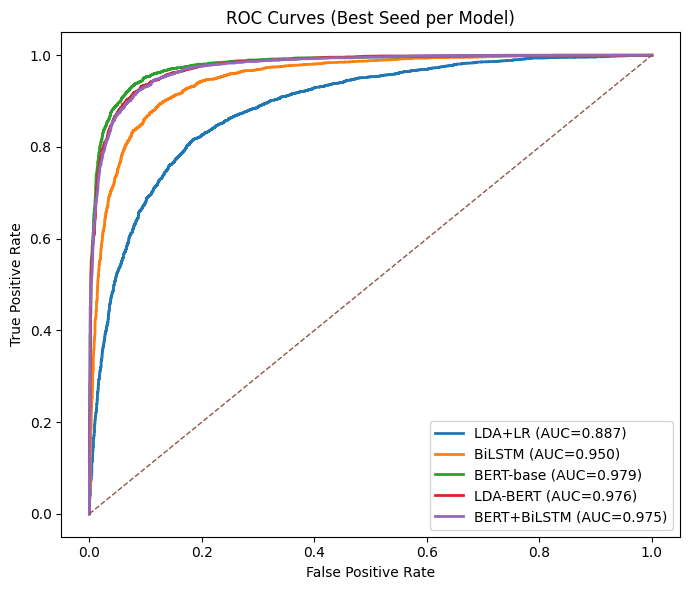

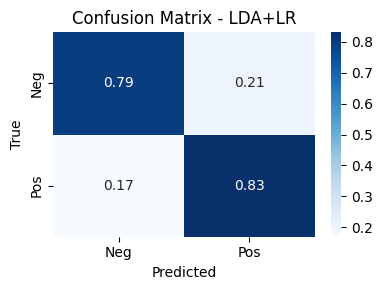

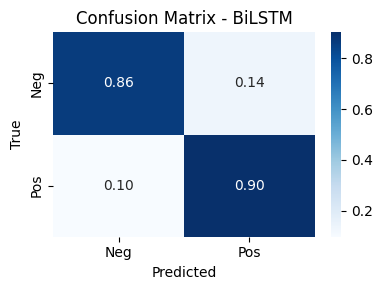

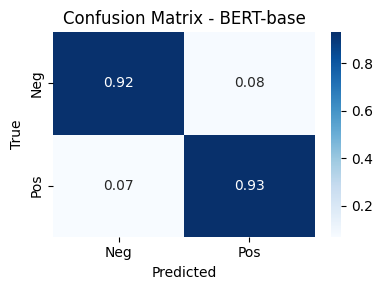

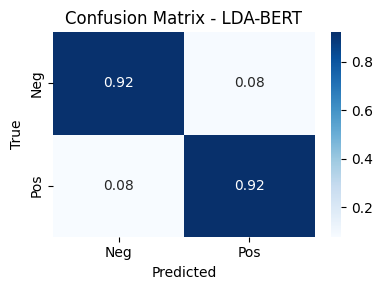

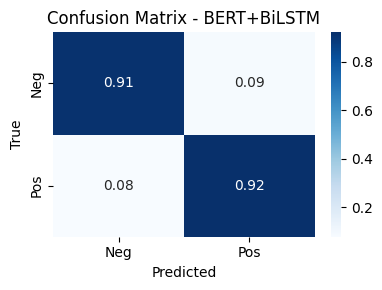

In [2]:
# Comprehensive Result Analyzer
# Features:
# ① Generate ROC curves, multi-model learning curves, t-test/Wilcoxon significance tests
# ② Output confusion matrices (with labels & percentages)
# ③ Extract error samples (high-confidence errors & boundary errors)

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
from scipy.stats import ttest_rel, wilcoxon

# ---- NEW: for HF datasets ----
from datasets import load_from_disk

# --- paths ---
RESULTS = Path("results")
PRED_DIR = RESULTS / "final_preds"
ERROR_DIR = RESULTS / "error_samples"; ERROR_DIR.mkdir(exist_ok=True)
FIG_DIR = RESULTS / "figs"; FIG_DIR.mkdir(exist_ok=True)
TAB_DIR = RESULTS / "tables"; TAB_DIR.mkdir(exist_ok=True)

# ---- NEW: dataset root (HF Arrow or CSV) ----
DATA_DIR = Path("data/imdb_kaggle_split_clean")

# --- models ---
MODELS = ["lda_lr", "bilstm", "bert", "lda_bert", "bert_bilstm"]
MODEL_NAMES = {
    "lda_lr": "LDA+LR",
    "bilstm": "BiLSTM",
    "bert": "BERT-base",
    "lda_bert": "LDA-BERT",
    "bert_bilstm": "BERT+BiLSTM"
}

# ---- NEW: generic loader (HF first, then CSV) ----
def load_split_df(data_dir: Path, split_name: str = "test") -> pd.DataFrame:
    """
    Try in order:
      1) load_from_disk(data_dir)[split_name]   # root is DatasetDict
      2) load_from_disk(data_dir/split_name)    # subdir is the split (your screenshot)
      3) data_dir/{split_name}.csv
    Returns a (possibly empty) DataFrame with normalized column names where possible.
    """
    # 1) DatasetDict at root
    try:
        ds_dict = load_from_disk(str(data_dir))
        if hasattr(ds_dict, "keys") and split_name in ds_dict:
            df = ds_dict[split_name].to_pandas().reset_index(drop=True)
            return _normalize_columns(df)
    except Exception:
        pass

    # 2) Standalone split directory (e.g., .../test/{state.json, data-00000...})
    try:
        split_path = data_dir / split_name
        if split_path.exists():
            ds = load_from_disk(str(split_path))
            df = ds.to_pandas().reset_index(drop=True)
            return _normalize_columns(df)
    except Exception:
        pass

    # 3) CSV fallback
    csv_path = data_dir / f"{split_name}.csv"
    if csv_path.exists():
        df = pd.read_csv(csv_path).reset_index(drop=True)
        return _normalize_columns(df)

    # none found
    print(f"⚠️ HuggingFace split '{split_name}' not found and {split_name}.csv missing under {data_dir}.")
    return pd.DataFrame()

def _normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Unify likely column names:
      text  <- one of ['text','review','content','sentence']
      label <- one of ['label','labels','sentiment','target','y']
      id    <- one of ['id','guid','index']
    Only rename if canonical name not already present.
    """
    rename_map = {}
    text_aliases  = ["text", "review", "content", "sentence"]
    label_aliases = ["label", "labels", "sentiment", "target", "y"]
    id_aliases    = ["id", "guid", "index"]

    if "text" not in df.columns:
        for c in text_aliases:
            if c in df.columns:
                rename_map[c] = "text"; break

    if "label" not in df.columns:
        for c in label_aliases:
            if c in df.columns:
                rename_map[c] = "label"; break

    if "id" not in df.columns:
        for c in id_aliases:
            if c in df.columns:
                rename_map[c] = "id"; break

    if rename_map:
        df = df.rename(columns=rename_map)
    return df

# =
# ① Paired t-test & Wilcoxon (cross-model performance significance comparison)
# =
def run_significance_tests(summary_path=RESULTS/"summary_best.csv"):
    if not summary_path.exists():
        print("⚠️ summary_best.csv not found, skipping statistics tests.")
        return
    df = pd.read_csv(summary_path)
    metrics = ["accuracy", "macro_f1", "auc"]
    records = []
    for i, m1 in enumerate(MODELS):
        for m2 in MODELS[i+1:]:
            if m1 not in df["model"].values or m2 not in df["model"].values:
                continue
            d1 = df.loc[df["model"]==m1, metrics].values
            d2 = df.loc[df["model"]==m2, metrics].values
            for j, met in enumerate(metrics):
                if len(d1)==0 or len(d2)==0: continue
                try:
                    tstat, tp = ttest_rel(d1[:,j], d2[:,j])
                    wstat, wp = wilcoxon(d1[:,j], d2[:,j])
                except Exception:
                    tstat=tp=wstat=wp=np.nan
                records.append({
                    "model_A": m1, "model_B": m2, "metric": met,
                    "A_mean": d1[:,j].mean(), "B_mean": d2[:,j].mean(),
                    "paired_t_stat": tstat, "paired_t_p": tp,
                    "wilcoxon_stat": wstat, "wilcoxon_p": wp,
                    "n": len(d1)
                })
    out = pd.DataFrame(records)
    out.to_csv(TAB_DIR/"stats_tests.csv", index=False)
    print(f" Significance tests -> {TAB_DIR/'stats_tests.csv'}")
    return out

# =
# ② ROC curves
# =
def plot_roc_all():
    plt.figure(figsize=(7,6))
    for m in MODELS:
        f = PRED_DIR / f"{m}.csv"
        if not f.exists(): continue
        df = pd.read_csv(f)
        # keep your original field names
        y_true = df["y_true"].to_numpy().astype(int)
        y_prob = df["y_proba"].to_numpy().astype(float)
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        plt.plot(fpr, tpr, lw=2, label=f"{MODEL_NAMES.get(m,m)} (AUC={auc(fpr,tpr):.3f})")
    plt.plot([0,1],[0,1],"--", lw=1)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Best Seed per Model)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(FIG_DIR/"roc_all.png", dpi=300)
    print(f" ROC -> {FIG_DIR/'roc_all.png'}")

# =
# ③ Confusion Matrix
# =
def plot_conf_matrix(model="bert_bilstm"):
    f = PRED_DIR / f"{model}.csv"
    if not f.exists():
        print(f"⚠️ {f} missing.")
        return
    df = pd.read_csv(f)
    y_true = df["y_true"].astype(int)
    y_pred = (df["y_proba"] >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt=".2f", xticklabels=["Neg","Pos"], yticklabels=["Neg","Pos"])
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title(f"Confusion Matrix - {MODEL_NAMES.get(model,model)}")
    plt.tight_layout()
    plt.savefig(FIG_DIR/f"cm_{model}.png", dpi=300)
    print(f" Confusion Matrix -> {FIG_DIR/f'cm_{model}.png'}")

# =
# ④ Error Sample Extraction (HF-aware)
# =
def export_errors(model="bert_bilstm"):
    f = PRED_DIR / f"{model}.csv"
    if not f.exists():
        print(f"⚠️ {f} not found, skip errors.")
        return

    df_pred = pd.read_csv(f).copy()

    # Try to load test split (HF first), else gracefully degrade to numeric-only
    test_df = load_split_df(DATA_DIR, "test")

    # original behavior: if cannot read text, export numeric-only with a clear message
    if test_df.empty:
        print(f"⚠️ Test text file not found ({DATA_DIR/'test'} or {DATA_DIR/'test.csv'}), exporting numeric columns only.")
        df = df_pred
    else:
        # optional: try align by 'id' if present, else assume same order
        if "id" in df_pred.columns and "id" in test_df.columns:
            # merge on id
            df = df_pred.merge(test_df[["id","text"]] if "text" in test_df.columns else test_df[["id"]],
                               on="id", how="left")
        else:
            # fall back to positional alignment (keeps your previous behavior)
            df = df_pred.copy()
            if "text" in test_df.columns:
                df["text"] = test_df["text"].values[:len(df)]

    df["y_pred"] = (df["y_proba"] >= 0.5).astype(int)
    df["error"] = df["y_pred"] != df["y_true"]
    df["margin"] = np.abs(df["y_proba"] - 0.5)
    wrong = df[df["error"]].copy()
    wrong["error_type"] = np.where(wrong["margin"]>0.4, "high_confidence_wrong", "near_boundary_wrong")
    out_path = ERROR_DIR / f"{model}_errors.csv"
    wrong.to_csv(out_path, index=False)
    print(f" Error samples -> {out_path} ({len(wrong)} rows)")
    return wrong

if __name__ == "__main__":
    print("Running comprehensive result analysis...\n")
    stats_df = run_significance_tests()
    plot_roc_all()
    for m in MODELS:
        plot_conf_matrix(m)
        export_errors(m)
    print("\n All analyses completed -> results/figs, results/tables, results/error_samples/")


In [2]:
# Setup & Helper Functions 
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from scipy.stats import ttest_rel, wilcoxon

#  Define directories 
RESULTS = Path("results")
FIG_DIR  = RESULTS / "figs";   FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR  = RESULTS / "tables"; TAB_DIR.mkdir(parents=True, exist_ok=True)
ERR_DIR  = RESULTS / "error_samples"; ERR_DIR.mkdir(parents=True, exist_ok=True)
LC_DIR   = RESULTS / "learning_curves"; LC_DIR.mkdir(parents=True, exist_ok=True)
PRED_DIR = RESULTS / "final_preds"

#  Model list and display names 
MODELS = ["lda_lr", "bilstm", "bert", "lda_bert", "bert_bilstm"]
MODEL_TITLES = {
    "lda_lr": "LDA + Logistic Regression",
    "bilstm": "BiLSTM",
    "bert": "BERT-base",
    "lda_bert": "LDA-BERT (Early Fusion)",
    "bert_bilstm": "BERT + BiLSTM",
}
METRICS = ["accuracy", "macro_f1", "auc"]

#  Load model results by name 
def load_runs(model):
    p = RESULTS / f"{model}_runs.csv"
    if not p.exists():
        return None
    df = pd.read_csv(p)
    if "seed" not in df.columns:
        return None
    for m in METRICS:
        if m not in df.columns:
            df[m] = np.nan
    return df

#  Format mean ± std for display 
def fmt_mean_std(xmean, xstd, prec=3):
    if pd.isna(xmean): 
        return "-"
    if pd.isna(xstd):  
        return f"{xmean:.{prec}f}"
    return f"{xmean:.{prec}f} ± {xstd:.{prec}f}"

print("✅ Setup OK")


✅ Setup OK


In [3]:
rows = []
for m in MODELS:
    df = load_runs(m)
    if df is None: 
        continue
    row = {"model": m, "Model": MODEL_TITLES.get(m, m)}
    # Compute mean and standard deviation for each metric and runtime
    for k in METRICS + ["time_sec"]:
        if k in df.columns:
            row[f"{k}_mean"] = df[k].mean()
            row[f"{k}_std"]  = df[k].std(ddof=1)
        else:
            row[f"{k}_mean"] = np.nan
            row[f"{k}_std"]  = np.nan
    rows.append(row)

tbl = pd.DataFrame(rows)
order_cols = ["Model"] + [f"{m}_mean" for m in METRICS] + [f"{m}_std" for m in METRICS] + ["time_sec_mean", "time_sec_std"]
tbl = tbl[["Model", "accuracy_mean", "accuracy_std",
            "macro_f1_mean", "macro_f1_std",
            "auc_mean", "auc_std",
            "time_sec_mean", "time_sec_std"]]

# Generate display table (formatted mean ± std)
show = pd.DataFrame({
    "Model": tbl["Model"],
    "Accuracy": [fmt_mean_std(a, b) for a, b in zip(tbl["accuracy_mean"], tbl["accuracy_std"])],
    "Macro-F1": [fmt_mean_std(a, b) for a, b in zip(tbl["macro_f1_mean"], tbl["macro_f1_std"])],
    "AUC": [fmt_mean_std(a, b) for a, b in zip(tbl["auc_mean"], tbl["auc_std"])],
    "Time (s)": [fmt_mean_std(a, b) for a, b in zip(tbl["time_sec_mean"], tbl["time_sec_std"])],
})
display_title = "Performance Comparison on IMDb (mean ± std over seeds)"
print(display_title)
display(show)

# Save results
tbl.to_csv(TAB_DIR / "summary_mean_std_raw.csv", index=False)
show.to_csv(TAB_DIR / "PerformanceComparison.csv", index=False)
print("✅ Saved:", TAB_DIR / "PerformanceComparison.csv")


Performance Comparison on IMDb (mean ± std over seeds)


,Model,Accuracy,Macro-F1,AUC,Time (s)
0,LDA + Logistic Regression,0.797 ± 0.013,0.797 ± 0.013,0.875 ± 0.012,167.328 ± 3.528
1,BiLSTM,0.874 ± 0.010,0.873 ± 0.010,0.943 ± 0.007,57.237 ± 1.428
2,BERT-base,0.927 ± 0.001,0.927 ± 0.001,0.978 ± 0.001,421.283 ± 26.205
3,LDA-BERT (Early Fusion),0.918 ± 0.001,0.918 ± 0.001,0.975 ± 0.001,379.922 ± 16.476
4,BERT + BiLSTM,0.915 ± 0.001,0.915 ± 0.001,0.974 ± 0.000,490.624 ± 2.427


✅ Saved: results/tables/PerformanceComparison.csv


In [4]:
#  Statistical significance (paired t-test & Wilcoxon) + p-value heatmaps 
def paired_vectors(dfA, dfB, metric):
    # Allow multiple rows per seed: take the mean per group and align
    a = dfA[["seed", metric]].copy(); a[metric] = pd.to_numeric(a[metric], errors="coerce")
    b = dfB[["seed", metric]].copy(); b[metric] = pd.to_numeric(b[metric], errors="coerce")
    a = a.groupby("seed", as_index=True)[metric].mean()
    b = b.groupby("seed", as_index=True)[metric].mean()
    common = a.index.intersection(b.index)
    if len(common) < 2:
        return None, None, []
    A = a.loc[common].astype(float).values
    B = b.loc[common].astype(float).values
    return A, B, list(common)

# Perform pairwise comparisons and store long-format results
records = []
models_present = []
runs = {}
for m in MODELS:
    df = load_runs(m)
    if df is not None:
        runs[m] = df
        models_present.append(m)

for i, m1 in enumerate(models_present):
    for m2 in models_present[i+1:]:
        df1, df2 = runs[m1], runs[m2]
        for met in METRICS:
            A, B, common = paired_vectors(df1, df2, met)
            if A is None:
                records.append({"model_A": m1, "model_B": m2, "metric": met, "n": 0,
                                "paired_t_p": np.nan, "wilcoxon_p": np.nan})
                continue
            tstat, tp = ttest_rel(A, B, nan_policy="omit")
            try:
                wstat, wp = wilcoxon(A, B, zero_method="wilcox", correction=False,
                                     alternative="two-sided", mode="auto")
            except Exception:
                wstat, wp = np.nan, np.nan
            records.append({
                "model_A": m1, "model_B": m2, "metric": met, "n": len(common),
                "A_mean": float(np.mean(A)), "B_mean": float(np.mean(B)),
                "paired_t_stat": float(tstat), "paired_t_p": float(tp),
                "wilcoxon_stat": float(wstat), "wilcoxon_p": float(wp)
            })

stats_df = pd.DataFrame(records)
stats_df.to_csv(TAB_DIR / "stats_tests.csv", index=False)
print("✅ Saved:", TAB_DIR / "stats_tests.csv")

# Plot p-value heatmaps (without seaborn)
def plot_p_heat(metric):
    models = models_present
    n = len(models)
    M = np.full((n, n), np.nan, dtype=float)
    for i, a in enumerate(models):
        for j, b in enumerate(models):
            if i == j:
                M[i, j] = 1.0
                continue
            row = stats_df[(stats_df["metric"] == metric) &
                           (((stats_df["model_A"] == a) & (stats_df["model_B"] == b)) |
                            ((stats_df["model_A"] == b) & (stats_df["model_B"] == a)))]
            if not row.empty:
                M[i, j] = float(row.iloc[0]["paired_t_p"])
    # Plotting
    plt.figure(figsize=(7, 6))
    im = plt.imshow(M, vmin=0, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04, label="p-value (paired t-test)")
    plt.xticks(range(n), [MODEL_TITLES.get(m, m) for m in models], rotation=30, ha="right")
    plt.yticks(range(n), [MODEL_TITLES.get(m, m) for m in models])
    # Annotate values
    for i in range(n):
        for j in range(n):
            if not np.isnan(M[i, j]):
                plt.text(j, i, f"{M[i, j]:.3f}", ha="center", va="center", fontsize=9)
    plt.title(f"Figure 4.{len(METRICS)+1}. Paired t-test p-values ({metric.upper()})")
    plt.tight_layout()
    out = FIG_DIR / f"ttest_heatmap_{metric}.png"
    plt.savefig(out, dpi=300)
    plt.close()
    print("✅ Saved:", out)

for met in METRICS:
    plot_p_heat(met)


✅ Saved: results/tables/stats_tests.csv
✅ Saved: results/figs/ttest_heatmap_accuracy.png
✅ Saved: results/figs/ttest_heatmap_macro_f1.png
✅ Saved: results/figs/ttest_heatmap_auc.png


In [5]:
#error analysis
# import pandas as pd
from pathlib import Path

#  locate the error CSV files
ERROR_DIR = Path("results/error_samples")

model_files = {
    "lda_lr": ERROR_DIR / "lda_lr_errors.csv",
    "bilstm": ERROR_DIR / "bilstm_errors.csv",
    "bert": ERROR_DIR / "bert_errors.csv",
    "lda_bert": ERROR_DIR / "lda_bert_errors.csv",
    "bert_bilstm": ERROR_DIR / "bert_bilstm_errors.csv",
}

def compute_metrics(df):
    total = len(df)

    # False Positives and False Negatives
    fp = ((df.y_true == 0) & (df.y_pred == 1)).sum()
    fn = ((df.y_true == 1) & (df.y_pred == 0)).sum()
    fp_rate = fp / total * 100
    fn_rate = fn / total * 100

    # High-confidence errors
    high_conf = (df.error_type == "high_confidence_wrong").mean() * 100

    # Mean confidence = max(p, 1 - p)
    mean_conf = df.y_proba.apply(lambda p: max(p, 1 - p)).mean()

    return {
        "FP (%)": fp_rate,
        "FN (%)": fn_rate,
        "High-Confidence Errors (%)": high_conf,
        "Mean Confidence": mean_conf
    }

# Compute results for all models
results = {
    model: compute_metrics(pd.read_csv(file))
    for model, file in model_files.items()
}

# Convert to DataFrame for better readability
df_results = pd.DataFrame(results).T
print(df_results)

# Save to the same directory
output_path = ERROR_DIR / "error_summary.csv"
df_results.to_csv(output_path, index=True)

print(f"\nSaved summary table to: {output_path}")

                FP (%)     FN (%)  High-Confidence Errors (%)  Mean Confidence
lda_lr       54.629630  45.370370                    5.911681         0.683624
bilstm       58.038769  41.961231                   33.523375         0.794872
bert         52.037037  47.962963                   74.629630         0.917852
lda_bert     51.070840  48.929160                   37.561779         0.803105
bert_bilstm  52.019386  47.980614                   46.688207         0.839054

Saved summary table to: results/error_samples/error_summary.csv
